In [7]:
from nltk import word_tokenize
import nltk
nltk.download('punkt')
from tqdm import tqdm_notebook as tqdm
import re
from collections import Counter
import numpy as np
import pickle as p
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Actual dataset

In [32]:
path_to_src_train = './rawdata/train/src.es'

path_to_trg_train = './rawdata/train/trg.en'

path_to_src_dev = './rawdata/dev/src.es'

path_to_trg_dev = './rawdata/dev/trg.en'

path_to_src_test = './rawdata/test/src.es'

path_to_trg_test = './rawdata/test/trg.en'

In [33]:
def parse_name_string(string):
    
    return re.sub(r'(?<=\.\/)[a-z]*', 'data', string)

def preprocess_line(line):
    
    return ' '.join(word_tokenize(line.lower()))

def preprocess_corpus(path):
    
    dest_path = parse_name_string(path)
    
    with open(path) as orig_file, open(dest_path, 'w') as dest_file:
        
        for line in tqdm(orig_file):
            
            dest_file.write(preprocess_line(line) + '\n')

In [34]:
preprocess_corpus(path_to_src_train)

preprocess_corpus(path_to_trg_train)

preprocess_corpus(path_to_src_dev)

preprocess_corpus(path_to_trg_dev)

preprocess_corpus(path_to_src_test)

preprocess_corpus(path_to_trg_test)

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


In [28]:
def build_unique_corpus(corpus_file):
    
    c = Counter()
    
    with open(corpus_file) as file:
        
        for line in file:
            
            c.update(line.split())
            
    return c

def write_vocab(corpus_file,
               vcb_path):
    
    vcb = build_unique_corpus(corpus_file)
    
    with open(vcb_path, 'w') as file:
        
        file.write('<unk>' + '\n')
        
        file.write('<s>' + '\n')
        
        file.write('</s>' + '\n')
        
        for elem in vcb:
            
            file.write(elem + '\n')
        

In [29]:
write_vocab('./data/train/src.es',
           './data/vcbs/src_vcb.txt')

write_vocab('./data/train/trg.en',
           './data/vcbs/trg_vcb.txt')

In [35]:
def build_ordered_vcb(vcb_file):
    
    c = {}
    
    with open(vcb_file) as file:
        
        for index, line in enumerate(file):
            
            c[line.strip()] = index
            
    return c

def fill_embedding_matrix(vcb_file,
                         embeddings_file,
                         spanish =  False):
    
    found = 0
        
    ordered_vcb = build_ordered_vcb(vcb_file)
    
    matrix = np.random.normal(size = (len(ordered_vcb), 100))
    
    with open(embeddings_file, encoding='utf8') as file:
        
        if spanish:
            
            file.readline()
        
        for line in tqdm(file):
            
            s = line.split()
            
            if len(s) > 101:
                
                continue
            
            w, v = s[0], s[1:]
            
            if w in ordered_vcb:
                
                matrix[ordered_vcb[w]] = np.array(list(map(float, v)))
                
                found += 1
                
    print('found {} out of {}'.format(found, len(ordered_vcb)))
    
    return matrix

In [51]:
src_matrix = fill_embedding_matrix('./data/vcbs/src_vcb.txt',
                                  './data/pretrained_embeddings/spanish_embeddings.txt',
                                  True)

trg_matrix = fill_embedding_matrix('./data/vcbs/trg_vcb.txt',
                                  './data/pretrained_embeddings/english_embeddings.txt')

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



found 59621 out of 83257



found 41486 out of 59465


In [53]:
p.dump(src_matrix, open('./data/pretrained_embeddings/src_embeddings_matrix.p', 'wb'))

p.dump(trg_matrix, open('./data/pretrained_embeddings/trg_embeddings_matrix.p', 'wb'))

# Debug dataset 

In [2]:
path_to_src_train = './data/train/src.es'

path_to_trg_train = './data/train/trg.en'

path_to_src_dev = './data/dev/src.es'

path_to_trg_dev = './data/dev/trg.en'

path_to_src_test = './data/test/src.es'

path_to_trg_test = './data/test/trg.en'

In [22]:
def _file_size(path):
    
    count = 0
    
    with open(path) as file:
        
        for line in file:
            
            count += 1
            
    return count

def _get_mask(size,
             subsample):
    
    mask = np.random.choice(size, 
                           size = int(size * subsample),
                           replace = False)
    
    return mask


def _parse_path(string):
    
    return re.sub(r'(?<=\.\/)[a-z]*', 'debug_data', string)


def _write_one_file(path,
                   dest_path,
                   mask):
    
    with open(dest_path, 'w') as dest_file, open(path) as file:
        
        for index, line in tqdm(enumerate(file)):
            
            if index in mask:
                
                dest_file.write(line)


def select_random_subsample(src_path,
                            trg_path,
                           subsample):
    
    original_size = _file_size(src_path)
    
    mask = _get_mask(original_size,
                    subsample)
    
    dest_src_path = _parse_path(src_path)
    
    dest_trg_path = _parse_path(trg_path)
    
    _write_one_file(src_path,
                   dest_src_path,
                   mask)
    
    _write_one_file(trg_path,
                   dest_trg_path,
                   mask)

In [30]:
fraction = 0.1

select_random_subsample(path_to_src_train,
                       path_to_trg_train,
                       fraction)

select_random_subsample(path_to_src_dev,
                       path_to_trg_dev,
                       fraction)

select_random_subsample(path_to_src_test,
                       path_to_trg_test,
                       fraction)

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [34]:
write_vocab('./debug_data/train/src.es',
           './debug_data/vcbs/src_vcb.txt')

write_vocab('./debug_data/train/trg.en',
           './debug_data/vcbs/trg_vcb.txt')

In [36]:
src_matrix = fill_embedding_matrix('./debug_data/vcbs/src_vcb.txt',
                                  './debug_data/pretrained_embeddings/spanish_embeddings.txt',
                                  True)

trg_matrix = fill_embedding_matrix('./debug_data/vcbs/trg_vcb.txt',
                                  './debug_data/pretrained_embeddings/english_embeddings.txt')

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:29: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



found 22415 out of 28044



found 18325 out of 21320


In [37]:
p.dump(src_matrix, open('./debug_data/pretrained_embeddings/src_embeddings_matrix.p', 'wb'))

p.dump(trg_matrix, open('./debug_data/pretrained_embeddings/trg_embeddings_matrix.p', 'wb'))

## Infer max seq lens

In [3]:
path_to_src_train = './data/train/src.es'

path_to_trg_train = './data/train/trg.en'

In [11]:
def _lens_collection(path):
    
    lens = []
    
    with open(path) as file:
        
        for line in file:
            
            lens.append(len(line.split()))
            
    return lens

def plot_distribution(path,
                     title):
    
    collection = _lens_collection(path)
    
    plt.figure(figsize = (5, 5))
    
    sns.distplot(collection)
    
    plt.title(title)
    
    plt.show()

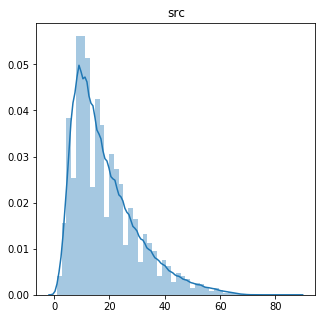

In [12]:
plot_distribution(path_to_src_train,
                 'src')

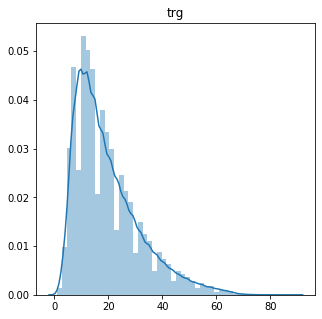

In [13]:
plot_distribution(path_to_trg_train,
                 'trg')